Gate median errors (percentage):
id: 0.0002738%
rx: 0.0002738%
rz: 0.0%
sx: 0.0002738%
x: 0.0002738%
cz: 0.001947%
rzz: 0.00249%
Gate: rz, Count: 3194
Gate: sx, Count: 2946
Gate: cz, Count: 2430
Gate: rx, Count: 928
Gate: rzz, Count: 348
Threshold: 0.200000, Expected Fidelity: 0.0012756890, Total Gates: 9846
Gate: rz, Count: 3578
Gate: sx, Count: 3302
Gate: cz, Count: 2724
Gate: rx, Count: 1040
Gate: rzz, Count: 390
Threshold: 0.164584, Expected Fidelity: 0.0005698649, Total Gates: 11034
Gate: rz, Count: 3964
Gate: sx, Count: 3660
Gate: cz, Count: 3018
Gate: rx, Count: 1152
Gate: rzz, Count: 432
Threshold: 0.135440, Expected Fidelity: 0.0002544258, Total Gates: 12226
Gate: rz, Count: 4294
Gate: sx, Count: 3966
Gate: cz, Count: 3270
Gate: rx, Count: 1248
Gate: rzz, Count: 468
Threshold: 0.111456, Expected Fidelity: 0.0001274919, Total Gates: 13246
Gate: rz, Count: 4679
Gate: sx, Count: 4323
Gate: cz, Count: 3564
Gate: rx, Count: 1360
Gate: rzz, Count: 510
Threshold: 0.091720, Expected F

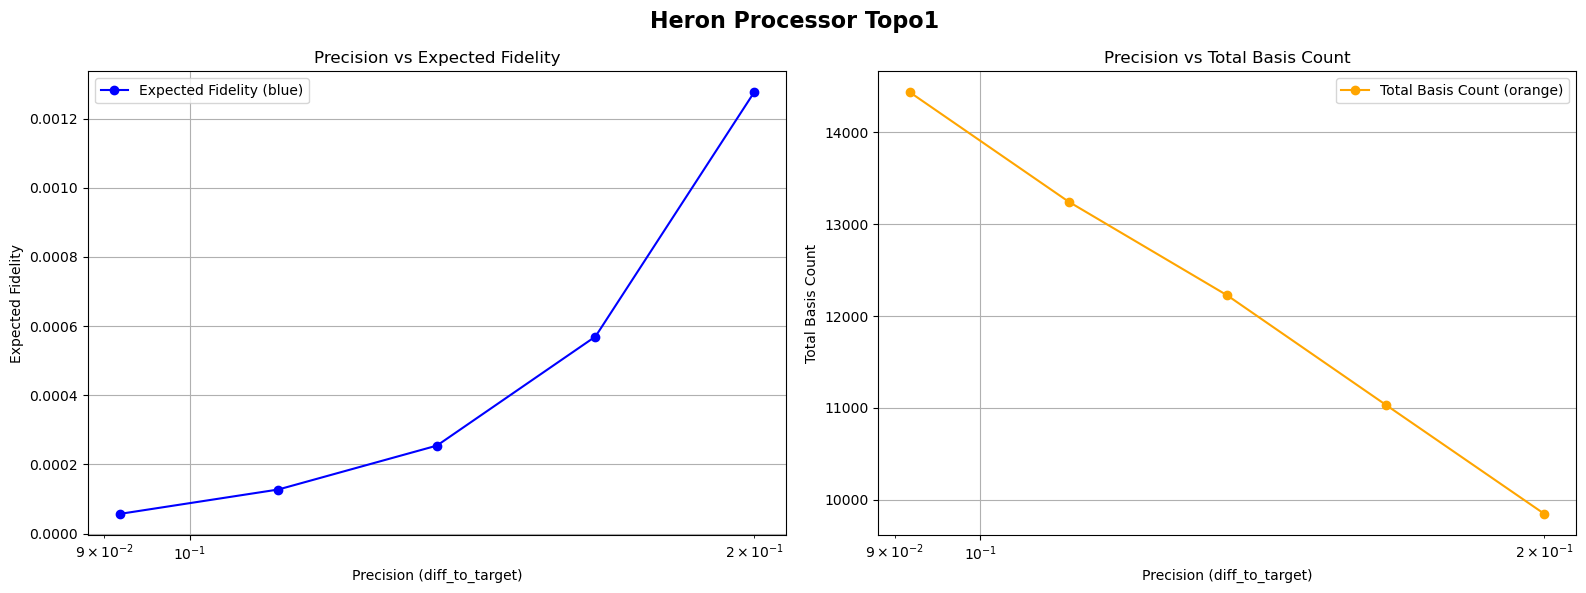

In [2]:
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.quantum_info import SparsePauliOp, Pauli
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.units import DistanceUnit
import numpy as np
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp
from qiskit.synthesis.evolution import SuzukiTrotter
from qiskit import transpile
from qiskit.transpiler import CouplingMap
from qiskit.transpiler import CouplingMap
import matplotlib.pyplot as plt
import numpy as np


n_qubits = 4
driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.742",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

molecule = driver.run()
mapper = JordanWignerMapper()
cost_h = mapper.map(molecule.hamiltonian.second_q_op())

driver_scaling = 0.27
driver_h = SparsePauliOp.from_list([
    ("XIII", -1.0*driver_scaling),
    ("IXII", -1.0*driver_scaling),
    ("IIXI", -1.0*driver_scaling),
    ("IIIX", -1.0*driver_scaling),
])


def build_commutator(op_a: SparsePauliOp, op_b: SparsePauliOp) -> SparsePauliOp:
    ab = op_a @ op_b
    ba = op_b @ op_a
    comm_pre= ab - ba
    comm = comm_pre*1j
    return comm.simplify()

comm_h=build_commutator(driver_h, cost_h)

def falqon_layer(qc,cost_h,driver_h,beta_k,delta_t):
    #synth = SuzukiTrotter(reps=1)   ,synthesis=synth
    U_c= PauliEvolutionGate(cost_h,delta_t)
    U_d= PauliEvolutionGate(beta_k*driver_h,delta_t)
    qc.append(U_c, range(qc.num_qubits))
    qc.append(U_d, range(qc.num_qubits))

E_set =-1.13728383


# 修改 main_loop 增加 diff_threshold 参数
def main_loop_2(qc, cost_h, driver_h, comm_h, delta_t, beta_0, n_steps, diff_threshold):
    beta = [beta_0]
    energies = []
    state = Statevector.from_label("+" * n_qubits)
    for i in range(n_steps):
        qc_layer = QuantumCircuit(n_qubits)
        falqon_layer(qc_layer, cost_h, driver_h, beta[i], delta_t)
        qc.compose(qc_layer, inplace=True)
        state = state.evolve(qc_layer) 
        energy = state.expectation_value(cost_h).real
        energies.append(energy)
        next_beta = -1 * state.expectation_value(comm_h).real
        beta.append(next_beta)

        if i >= 1:
            diff_to_target = abs(energies[-1] - E_set)
            if diff_to_target < diff_threshold:
                break

    return beta, energies, qc


def uniform_superposition_circuit(n_qubits=4):
    qc = QuantumCircuit(n_qubits)
    qc.h(range(n_qubits))  # 对所有 qubit 施加 H 门
    return qc

def calculate_expected_fidelity(gate_error, count_ops):
    fidelity = 1.0
    for gate, error_rate in gate_error.items():
        count = count_ops.get(gate, 0)  # 如果电路里没有这个门，默认 count=0
        fidelity *= (1 - error_rate) ** count
        #print(f"Gate: {gate}, Count: {count}, Error: {error_rate}, Contribution: {(1 - error_rate) ** count:.6f}")
    return fidelity

qc_initial= uniform_superposition_circuit()

n_steps = 1000
beta_0 = 0.0
delta_t = 0.03

basis_gates = ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x']

gate_error_heron = {
    "id": 2.738e-4,      # 1-qubit
    "rx": 2.738e-4,      # 1-qubit
    "rz": 0.0,           # 1-qubit
    "sx": 2.738e-4,      # 1-qubit
    "x": 2.738e-4,       # 1-qubit
    "cz": 1.947e-3,      # 2-qubit
    "rzz": 2.490e-3      # 2-qubit
}

basis_gates_eagle = ['ecr', 'id', 'rz', 'sx', 'x']

gate_error_eagle= {
    "ecr": 5.824e-3,      
    "id": 2.252e-4,      
    "rz": 0.0,           
    "sx": 2.252e-4,      
    "x": 2.252e-4,       
}
gate_error= gate_error_heron
coupling_map = CouplingMap.from_full(4)

# 定义线性拓扑：0–1–2–3
linear_coupling = CouplingMap(couplinglist=[(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2)])

# Print out for checking
print("Gate median errors (percentage):")
for gate, error in gate_error.items():
    print(f"{gate}: {error}%")


# 生成 diff_to_target 阈值数组
precision_list = np.logspace(np.log10(0.2), np.log10(0.0001), 40)
fidelity_list = []

total_count_list = []  # 存储每个 precision 下的 gate 总数
for threshold in precision_list:
    # 初始化电路
    qc_initial = uniform_superposition_circuit()
    
    # 运行 main_loop
    beta_list, energy_list, final_circuit = main_loop_2(
        qc=qc_initial,
        cost_h=cost_h,
        driver_h=driver_h,
        comm_h=comm_h,
        delta_t=delta_t,
        beta_0=beta_0,
        n_steps=n_steps,
        diff_threshold=threshold
    )

    # Transpile 电路
    transpiled_circuit = transpile(
        final_circuit,
        basis_gates=basis_gates,
        coupling_map=linear_coupling,
        optimization_level=1
    )

    # 统计 gate count
    gate_counts = transpiled_circuit.count_ops()
    total_count = sum(gate_counts.values())  # 所有 gate 总数
    total_count_list.append(total_count)
    for gate, count in transpiled_circuit.count_ops().items():
        print(f"Gate: {gate}, Count: {count}")


    # 计算 expected fidelity
    expected_fidelity = calculate_expected_fidelity(gate_error, gate_counts)
    fidelity_list.append(expected_fidelity)
    print(f"Threshold: {threshold:.6f}, Expected Fidelity: {expected_fidelity:.10f}, Total Gates: {total_count}")

    if fidelity_list[-1] < 0.0001:
        print("Expected fidelity reached zero, exiting loop early.")
        break


import matplotlib.pyplot as plt

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Main title for the entire figure
fig.suptitle('Heron Processor Topo1', fontsize=16, fontweight='bold')

# Plot 1: Precision vs Expected Fidelity
ax1.plot(precision_list[:len(fidelity_list)], fidelity_list, marker='o', label='Expected Fidelity (blue)', color='blue')
ax1.set_xscale('log')
ax1.set_xlabel('Precision (diff_to_target)')
ax1.set_ylabel('Expected Fidelity')
ax1.set_title('Precision vs Expected Fidelity')
ax1.grid(True)
ax1.legend()

# Plot 2: Precision vs Total Basis Count
ax2.plot(precision_list[:len(total_count_list)], total_count_list, marker='o', color='orange', label='Total Basis Count (orange)')
ax2.set_xscale('log')
ax2.set_xlabel('Precision (diff_to_target)')
ax2.set_ylabel('Total Basis Count')
ax2.set_title('Precision vs Total Basis Count')
ax2.grid(True)
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined plot
plt.show()


In [3]:
print("Precisions used in the plot (log-spaced thresholds):")
for i, prec in enumerate(precision_list[:len(fidelity_list)]):
    print(f"{i+1:2d}: {prec:.6e}")


Precisions used in the plot (log-spaced thresholds):
 1: 2.000000e-01
 2: 1.645842e-01
 3: 1.354398e-01
 4: 1.114563e-01
 5: 9.171974e-02


Gate median errors (percentage):
ecr: 0.005824%
id: 0.0002252%
rz: 0.0%
sx: 0.0002252%
x: 0.0002252%
Gate: rz, Count: 6602
Gate: sx, Count: 3477
Gate: ecr, Count: 3126
Gate: x, Count: 1277
Threshold: 0.200000, Expected Fidelity: 0.0000000040, Total Gates: 14482
Expected fidelity reached zero, exiting loop early.


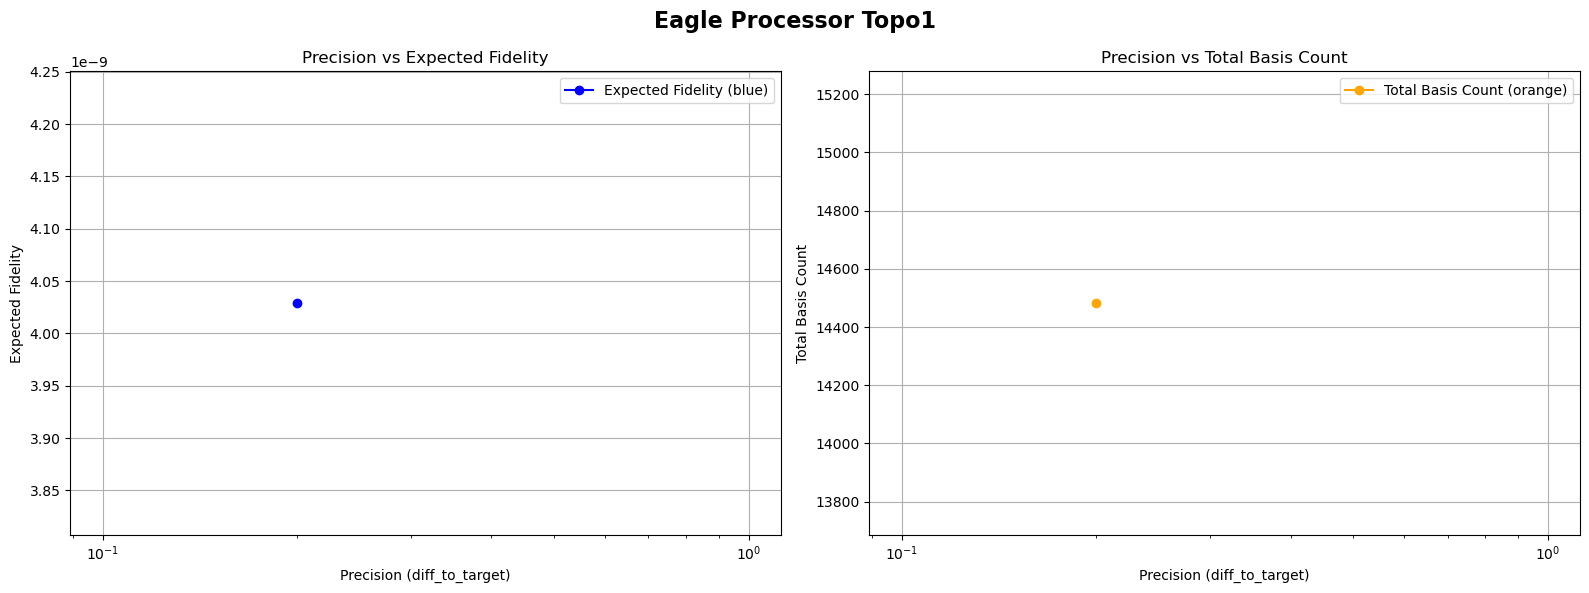

In [9]:

basis_gates = ['cz', 'id', 'rx', 'rz', 'rzz', 'sx', 'x']

gate_error_heron = {
    "id": 2.738e-4,      # 1-qubit
    "rx": 2.738e-4,      # 1-qubit
    "rz": 0.0,           # 1-qubit
    "sx": 2.738e-4,      # 1-qubit
    "x": 2.738e-4,       # 1-qubit
    "cz": 1.947e-3,      # 2-qubit
    "rzz": 2.490e-3      # 2-qubit
}

basis_gates_eagle = ['ecr', 'id', 'rz', 'sx', 'x']

gate_error_eagle= {
    "ecr": 5.824e-3,      
    "id": 2.252e-4,      
    "rz": 0.0,           
    "sx": 2.252e-4,      
    "x": 2.252e-4,       
}
gate_error= gate_error_eagle
coupling_map = CouplingMap.from_full(4)

# 定义线性拓扑：0–1–2–3
linear_coupling = CouplingMap(couplinglist=[(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2)])

# Print out for checking
print("Gate median errors (percentage):")
for gate, error in gate_error.items():
    print(f"{gate}: {error}%")


# 生成 diff_to_target 阈值数组
precision_list = np.logspace(np.log10(0.2), np.log10(0.0001), 40)
fidelity_list = []

total_count_list = []  # 存储每个 precision 下的 gate 总数
for threshold in precision_list:
    # 初始化电路
    qc_initial = uniform_superposition_circuit()
    
    # 运行 main_loop
    beta_list, energy_list, final_circuit = main_loop_2(
        qc=qc_initial,
        cost_h=cost_h,
        driver_h=driver_h,
        comm_h=comm_h,
        delta_t=delta_t,
        beta_0=beta_0,
        n_steps=n_steps,
        diff_threshold=threshold
    )

    # Transpile 电路
    transpiled_circuit = transpile(
        final_circuit,
        basis_gates=basis_gates_eagle,
        coupling_map=linear_coupling,
        optimization_level=1
    )

    # 统计 gate count
    gate_counts = transpiled_circuit.count_ops()
    total_count = sum(gate_counts.values())  # 所有 gate 总数
    total_count_list.append(total_count)
    for gate, count in transpiled_circuit.count_ops().items():
        print(f"Gate: {gate}, Count: {count}")


    # 计算 expected fidelity
    expected_fidelity = calculate_expected_fidelity(gate_error, gate_counts)
    fidelity_list.append(expected_fidelity)
    print(f"Threshold: {threshold:.6f}, Expected Fidelity: {expected_fidelity:.10f}, Total Gates: {total_count}")

    if fidelity_list[-1] < 0.0001:
        print("Expected fidelity reached zero, exiting loop early.")
        break

# 绘图1: Precision vs Expected Fidelity
import matplotlib.pyplot as plt

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Main title for the entire figure
fig.suptitle('Eagle Processor Topo1', fontsize=16, fontweight='bold')

# Plot 1: Precision vs Expected Fidelity
ax1.plot(precision_list[:len(fidelity_list)], fidelity_list, marker='o', label='Expected Fidelity (blue)', color='blue')
ax1.set_xscale('log')
ax1.set_xlabel('Precision (diff_to_target)')
ax1.set_ylabel('Expected Fidelity')
ax1.set_title('Precision vs Expected Fidelity')
ax1.grid(True)
ax1.legend()

# Plot 2: Precision vs Total Basis Count
ax2.plot(precision_list[:len(total_count_list)], total_count_list, marker='o', color='orange', label='Total Basis Count (orange)')
ax2.set_xscale('log')
ax2.set_xlabel('Precision (diff_to_target)')
ax2.set_ylabel('Total Basis Count')
ax2.set_title('Precision vs Total Basis Count')
ax2.grid(True)
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined plot
plt.show()

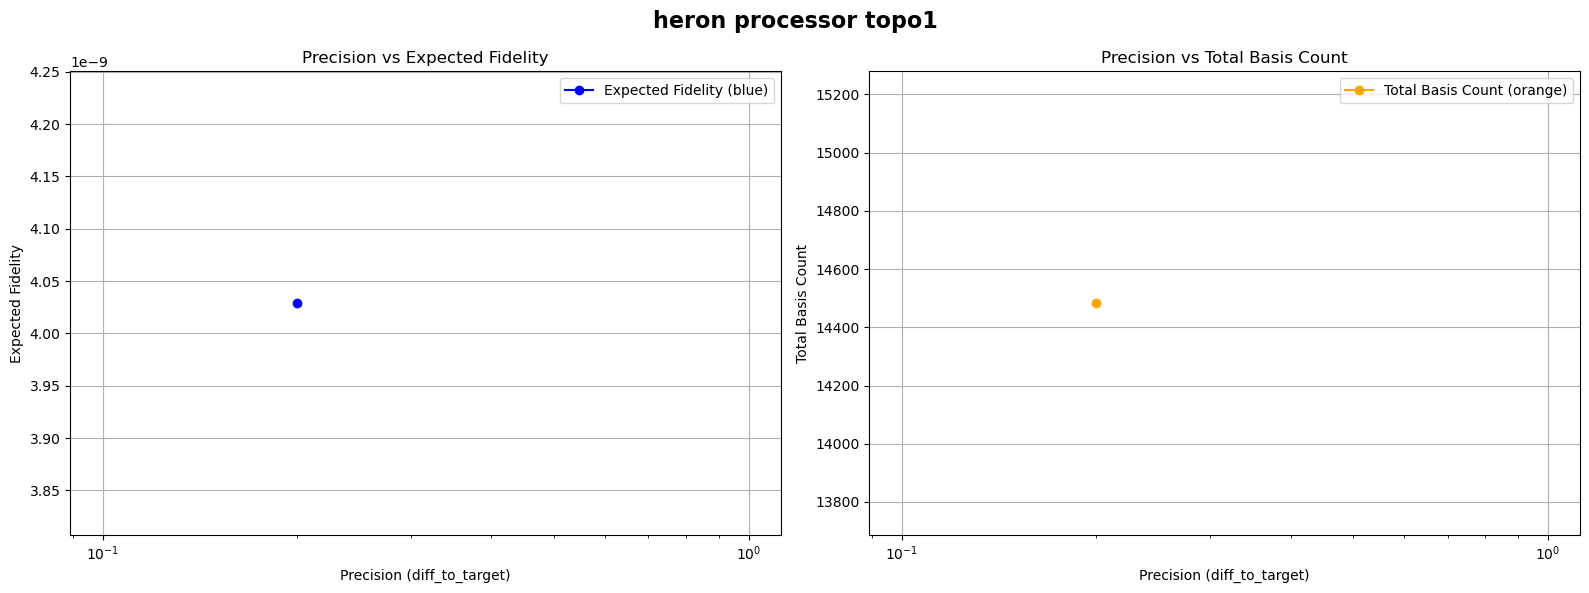

In [4]:
import matplotlib.pyplot as plt

# Create a figure with 2 subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Main title for the entire figure
fig.suptitle('heron processor topo1', fontsize=16, fontweight='bold')

# Plot 1: Precision vs Expected Fidelity
ax1.plot(precision_list[:len(fidelity_list)], fidelity_list, marker='o', label='Expected Fidelity (blue)', color='blue')
ax1.set_xscale('log')
ax1.set_xlabel('Precision (diff_to_target)')
ax1.set_ylabel('Expected Fidelity')
ax1.set_title('Precision vs Expected Fidelity')
ax1.grid(True)
ax1.legend()

# Plot 2: Precision vs Total Basis Count
ax2.plot(precision_list[:len(total_count_list)], total_count_list, marker='o', color='orange', label='Total Basis Count (orange)')
ax2.set_xscale('log')
ax2.set_xlabel('Precision (diff_to_target)')
ax2.set_ylabel('Total Basis Count')
ax2.set_title('Precision vs Total Basis Count')
ax2.grid(True)
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined plot
plt.show()

In [5]:
qc = QuantumCircuit(4)
qc =final_circuit
total_count_list = []
basis_gates = ['cx', 'rz', 'sx']
linear_coupling1= CouplingMap(couplinglist=[(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2)])
t1 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling,
        optimization_level=1
    )
print("1:", t1.count_ops())

linear_coupling2 = CouplingMap(couplinglist=[(0, 1), (1, 0), (1, 3), (3, 1), (2, 3), (3, 2)])
t2 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling2,
        optimization_level=1
    )
print("2:", t2.count_ops())

linear_coupling3 = CouplingMap(couplinglist=[(0, 2), (2, 0), (1, 2), (2, 1), (1, 3), (3, 1)])
t3 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling3,
        optimization_level=1
    )
print("3:", t3.count_ops())

linear_coupling4 = CouplingMap(couplinglist=[(0, 2), (2, 0), (2, 3), (3, 2), (1, 3), (3, 1)])
t4 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling4,
        optimization_level=1
    )
print("4:", t4.count_ops())
linear_coupling5 = CouplingMap(couplinglist=[(0, 3), (3, 0), (1, 3), (3, 1), (1, 2), (2, 1)])
t5 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling5,
        optimization_level=1
    )
print("5:", t5.count_ops())

linear_coupling6 = CouplingMap(couplinglist=[(0, 3), (3, 0), (2, 3), (3, 2), (1, 2), (2, 1)])
t6 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling6,
        optimization_level=1
    )
print("6:", t6.count_ops())

linear_coupling7 = CouplingMap(couplinglist=[(1, 0), (0, 1), (0, 2), (2, 0), (2, 3), (3, 2)])
t7 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling7,
        optimization_level=1
    )
print("7:", t7.count_ops())
linear_coupling8 = CouplingMap(couplinglist=[(1, 0), (0, 1), (0, 3), (3, 0), (2, 3), (3, 2)])
t8 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling8,
        optimization_level=1
    )
print("8:", t8.count_ops())

linear_coupling9 = CouplingMap(couplinglist=[(1, 2), (2, 1), (2, 3), (3, 2), (0, 3), (3, 0)])
t9 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling9,
        optimization_level=1
    )
print("9:", t9.count_ops())

linear_coupling10 = CouplingMap(couplinglist=[(1, 2), (2, 1), (2, 0), (0, 2), (0, 3), (3, 0)])
t10 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling10,
        optimization_level=1
    )
print("10:", t10.count_ops())

linear_coupling11 = CouplingMap(couplinglist=[(1, 3), (3, 1), (0, 2), (2, 0), (0, 3), (3, 0)])
t11 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling11,
        optimization_level=1
    )
print("11:", t11.count_ops())
linear_coupling12 = CouplingMap(couplinglist=[(1, 3), (3, 1), (0, 2), (2, 0), (2, 3), (3, 2)])
t12 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling12,
        optimization_level=1
    )
print("12:", t12.count_ops())

linear_coupling13 = CouplingMap(couplinglist=[(2, 0), (0, 2), (1, 0), (0, 1), (1, 3), (3, 1)])
t13 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling13,
        optimization_level=1
    )
print("13:", t13.count_ops())
linear_coupling14 = CouplingMap(couplinglist=[(2, 0), (0, 2), (3, 0), (0, 3), (1, 3), (3, 1)])
t14 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling14,
        optimization_level=1
    )
print("14:", t14.count_ops())

linear_coupling15 = CouplingMap(couplinglist=[(2, 1), (1, 2), (0, 1), (1, 0), (0, 3), (3, 0)])
t15 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling15,
        optimization_level=1
    )
print("15:", t15.count_ops())
linear_coupling16 = CouplingMap(couplinglist=[(2, 1), (1, 2), (0, 3), (3, 0), (3, 1), (1, 3)])
t16 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling16,
        optimization_level=1
    )
print("16:", t16.count_ops())

linear_coupling17 = CouplingMap(couplinglist=[(2, 3), (3, 2), (0, 1), (1, 0), (1, 3), (3, 1)])
t17 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling17,
        optimization_level=1
    )
print("17:", t17.count_ops())

linear_coupling18 = CouplingMap(couplinglist=[(2, 3), (3, 2), (0, 1), (1, 0), (0, 3), (3, 0)])
t18 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling18,
        optimization_level=1
    )
print("18:", t18.count_ops())

linear_coupling19 = CouplingMap(couplinglist=[(3, 0), (0, 3), (1, 0), (0, 1), (1, 2), (2, 1)])
t19 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling19,
        optimization_level=1
    )
print("19:", t19.count_ops())
linear_coupling20 = CouplingMap(couplinglist=[(3, 0), (0, 3), (2, 0), (0, 2), (1, 2), (2, 1)])
t20 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling20,
        optimization_level=1
    )
print("20:", t20.count_ops())

linear_coupling21 = CouplingMap(couplinglist=[(3, 1), (1, 3), (0, 1), (1, 0), (0, 2), (2, 0)])
t21 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling21,
        optimization_level=1
    )
print("21:", t21.count_ops())
linear_coupling22 = CouplingMap(couplinglist=[(3, 1), (1, 3), (0, 2), (2, 0), (2, 1), (1, 2)])
t22 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling22,
        optimization_level=1
    )
print("22:", t22.count_ops())

linear_coupling23 = CouplingMap(couplinglist=[(3, 2), (2, 3), (0, 1), (1, 0), (0, 2), (2, 0)])
t23 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling23,
        optimization_level=1
    )
print("23:", t23.count_ops())
linear_coupling24 = CouplingMap(couplinglist=[(3, 2), (2, 3), (0, 1), (1, 0), (1, 2), (2, 1)])
t24 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling24,
        optimization_level=1
    )
print("24:", t24.count_ops())

1: OrderedDict([('cx', 3126), ('rz', 2032), ('sx', 1274)])
2: OrderedDict([('cx', 3126), ('rz', 2032), ('sx', 1274)])
3: OrderedDict([('cx', 3126), ('rz', 2032), ('sx', 1274)])
4: OrderedDict([('cx', 3126), ('rz', 2032), ('sx', 1274)])
5: OrderedDict([('cx', 3126), ('rz', 2032), ('sx', 1274)])
6: OrderedDict([('cx', 3126), ('rz', 2032), ('sx', 1274)])
7: OrderedDict([('cx', 3126), ('rz', 2032), ('sx', 1274)])
8: OrderedDict([('cx', 3126), ('rz', 2032), ('sx', 1274)])
9: OrderedDict([('cx', 3126), ('rz', 2032), ('sx', 1274)])
10: OrderedDict([('cx', 3126), ('rz', 2032), ('sx', 1274)])
11: OrderedDict([('cx', 3126), ('rz', 2032), ('sx', 1274)])
12: OrderedDict([('cx', 3126), ('rz', 2032), ('sx', 1274)])
13: OrderedDict([('cx', 3126), ('rz', 2032), ('sx', 1274)])
14: OrderedDict([('cx', 3126), ('rz', 2032), ('sx', 1274)])
15: OrderedDict([('cx', 3126), ('rz', 2032), ('sx', 1274)])
16: OrderedDict([('cx', 3126), ('rz', 2032), ('sx', 1274)])
17: OrderedDict([('cx', 3126), ('rz', 2032), ('sx

In [6]:
qc = QuantumCircuit(4)
qc =final_circuit
total_count_list = []
basis_gates = ['cx', 'rz', 'sx']
linear_coupling1= CouplingMap(couplinglist=[(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2)])
t1 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling,
        optimization_level=0
    )
print("1:", t1.count_ops())

linear_coupling2 = CouplingMap(couplinglist=[(0, 1), (1, 0), (1, 3), (3, 1), (2, 3), (3, 2)])
t2 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling2,
        optimization_level=0
    )
print("2:", t2.count_ops())

linear_coupling3 = CouplingMap(couplinglist=[(0, 2), (2, 0), (1, 2), (2, 1), (1, 3), (3, 1)])
t3 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling3,
        optimization_level=0
    )
print("3:", t3.count_ops())

linear_coupling4 = CouplingMap(couplinglist=[(0, 2), (2, 0), (2, 3), (3, 2), (1, 3), (3, 1)])
t4 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling4,
        optimization_level=0
    )
print("4:", t4.count_ops())
linear_coupling5 = CouplingMap(couplinglist=[(0, 3), (3, 0), (1, 3), (3, 1), (1, 2), (2, 1)])
t5 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling5,
        optimization_level=0
    )
print("5:", t5.count_ops())

linear_coupling6 = CouplingMap(couplinglist=[(0, 3), (3, 0), (2, 3), (3, 2), (1, 2), (2, 1)])
t6 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling6,
        optimization_level=0
    )
print("6:", t6.count_ops())

linear_coupling7 = CouplingMap(couplinglist=[(1, 0), (0, 1), (0, 2), (2, 0), (2, 3), (3, 2)])
t7 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling7,
        optimization_level=0
    )
print("7:", t7.count_ops())
linear_coupling8 = CouplingMap(couplinglist=[(1, 0), (0, 1), (0, 3), (3, 0), (2, 3), (3, 2)])
t8 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling8,
        optimization_level=0
    )
print("8:", t8.count_ops())

linear_coupling9 = CouplingMap(couplinglist=[(1, 2), (2, 1), (2, 3), (3, 2), (0, 3), (3, 0)])
t9 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling9,
        optimization_level=0
    )
print("9:", t9.count_ops())

linear_coupling10 = CouplingMap(couplinglist=[(1, 2), (2, 1), (2, 0), (0, 2), (0, 3), (3, 0)])
t10 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling10,
        optimization_level=0
    )
print("10:", t10.count_ops())

linear_coupling11 = CouplingMap(couplinglist=[(1, 3), (3, 1), (0, 2), (2, 0), (0, 3), (3, 0)])
t11 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling11,
        optimization_level=0
    )
print("11:", t11.count_ops())
linear_coupling12 = CouplingMap(couplinglist=[(1, 3), (3, 1), (0, 2), (2, 0), (2, 3), (3, 2)])
t12 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling12,
        optimization_level=0
    )
print("12:", t12.count_ops())

linear_coupling13 = CouplingMap(couplinglist=[(2, 0), (0, 2), (1, 0), (0, 1), (1, 3), (3, 1)])
t13 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling13,
        optimization_level=0
    )
print("13:", t13.count_ops())
linear_coupling14 = CouplingMap(couplinglist=[(2, 0), (0, 2), (3, 0), (0, 3), (1, 3), (3, 1)])
t14 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling14,
        optimization_level=0
    )
print("14:", t14.count_ops())

linear_coupling15 = CouplingMap(couplinglist=[(2, 1), (1, 2), (0, 1), (1, 0), (0, 3), (3, 0)])
t15 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling15,
        optimization_level=0
    )
print("15:", t15.count_ops())
linear_coupling16 = CouplingMap(couplinglist=[(2, 1), (1, 2), (0, 3), (3, 0), (3, 1), (1, 3)])
t16 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling16,
        optimization_level=0
    )
print("16:", t16.count_ops())

linear_coupling17 = CouplingMap(couplinglist=[(2, 3), (3, 2), (0, 1), (1, 0), (1, 3), (3, 1)])
t17 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling17,
        optimization_level=0
    )
print("17:", t17.count_ops())

linear_coupling18 = CouplingMap(couplinglist=[(2, 3), (3, 2), (0, 1), (1, 0), (0, 3), (3, 0)])
t18 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling18,
        optimization_level=0
    )
print("18:", t18.count_ops())

linear_coupling19 = CouplingMap(couplinglist=[(3, 0), (0, 3), (1, 0), (0, 1), (1, 2), (2, 1)])
t19 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling19,
        optimization_level=0
    )
print("19:", t19.count_ops())
linear_coupling20 = CouplingMap(couplinglist=[(3, 0), (0, 3), (2, 0), (0, 2), (1, 2), (2, 1)])
t20 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling20,
        optimization_level=0
    )
print("20:", t20.count_ops())

linear_coupling21 = CouplingMap(couplinglist=[(3, 1), (1, 3), (0, 1), (1, 0), (0, 2), (2, 0)])
t21 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling21,
        optimization_level=0
    )
print("21:", t21.count_ops())
linear_coupling22 = CouplingMap(couplinglist=[(3, 1), (1, 3), (0, 2), (2, 0), (2, 1), (1, 2)])
t22 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling22,
        optimization_level=0
    )
print("22:", t22.count_ops())

linear_coupling23 = CouplingMap(couplinglist=[(3, 2), (2, 3), (0, 1), (1, 0), (0, 2), (2, 0)])
t23 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling23,
        optimization_level=0
    )
print("23:", t23.count_ops())
linear_coupling24 = CouplingMap(couplinglist=[(3, 2), (2, 3), (0, 1), (1, 0), (1, 2), (2, 1)])
t24 = transpile(
        qc,
        basis_gates=basis_gates,
        coupling_map=linear_coupling24,
        optimization_level=0
    )
print("24:", t24.count_ops())

1: OrderedDict([('rz', 6144), ('cx', 3894), ('sx', 2316)])
2: OrderedDict([('rz', 6144), ('cx', 3945), ('sx', 2316)])
3: OrderedDict([('rz', 6144), ('cx', 3978), ('sx', 2316)])
4: OrderedDict([('rz', 6144), ('cx', 3894), ('sx', 2316)])
5: OrderedDict([('rz', 6144), ('cx', 4074), ('sx', 2316)])
6: OrderedDict([('rz', 6144), ('cx', 3999), ('sx', 2316)])
7: OrderedDict([('rz', 6144), ('cx', 3657), ('sx', 2316)])
8: OrderedDict([('rz', 6144), ('cx', 3861), ('sx', 2316)])
9: OrderedDict([('rz', 6144), ('cx', 4038), ('sx', 2316)])
10: OrderedDict([('rz', 6144), ('cx', 3864), ('sx', 2316)])
11: OrderedDict([('rz', 6144), ('cx', 4080), ('sx', 2316)])
12: OrderedDict([('rz', 6144), ('cx', 4071), ('sx', 2316)])
13: OrderedDict([('rz', 6144), ('cx', 3957), ('sx', 2316)])
14: OrderedDict([('rz', 6144), ('cx', 3960), ('sx', 2316)])
15: OrderedDict([('rz', 6144), ('cx', 3966), ('sx', 2316)])
16: OrderedDict([('rz', 6144), ('cx', 3981), ('sx', 2316)])
17: OrderedDict([('rz', 6144), ('cx', 3855), ('sx